In [40]:
import os
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [41]:
import numpy as np
import random
import time
random.seed(int(time.time()))

resize_shape = (62, 62)

def build_data(path):
    datas = []
    for file_path in tqdm(os.listdir(path)):
        img = cv2.imread(os.path.join(path, file_path))
        img = cv2.resize(img, resize_shape) / 255.0
        datas.append(img)
    print('img num in %s is %d' % (path, len(datas)))
    return datas


train_x = []
train_y = []
val_x = []
val_y = []

In [42]:
with_mask_imgs = build_data(os.path.join('./data', 'with_mask'))

100%|█████████████████████████████████████████████████████████████████████████████| 1064/1064 [00:01<00:00, 537.44it/s]


img num in ./data\with_mask is 1064


In [43]:
without_mask_imgs = build_data(os.path.join('./data', 'without_mask'))

100%|█████████████████████████████████████████████████████████████████████████████| 1727/1727 [00:02<00:00, 687.46it/s]


img num in ./data\without_mask is 1727


In [44]:
random.shuffle(without_mask_imgs)
without_mask_imgs = without_mask_imgs[:len(with_mask_imgs)]
len(without_mask_imgs)

1064

In [45]:
ratio = 0.8
data_len = len(without_mask_imgs)

In [46]:
train_x += with_mask_imgs[:int(data_len * ratio)]
train_y += [1] * int(data_len * ratio)
val_x += with_mask_imgs[int(data_len * ratio):]
val_y += [1] * (data_len - int(data_len * ratio))

In [47]:
train_x += without_mask_imgs[:int(data_len * ratio)]
train_y += [0] * int(data_len * ratio)
val_x += without_mask_imgs[int(data_len * ratio):]
val_y += [0] * (data_len - int(data_len * ratio))

In [48]:
train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

print('train_x.shape =', train_x.shape)
print('train_y.shape =', train_y.shape)
print('val_x.shape =', val_x.shape)
print('val_y.shape =', val_y.shape)

train_x.shape = (1702, 62, 62, 3)
train_y.shape = (1702,)
val_x.shape = (426, 62, 62, 3)
val_y.shape = (426,)


In [49]:
import keras
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Input, Activation, Dense, Flatten, Dropout, AveragePooling2D
from keras.callbacks import EarlyStopping

In [225]:
def get_model(shape):

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 1)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (1, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    return model

In [226]:
model = get_model(train_x[0].shape)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='auto', patience=3)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 60, 60, 32)        896       
_________________________________________________________________
activation_86 (Activation)   (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 28, 30, 32)        3104      
_________________________________________________________________
activation_87 (Activation)   (None, 28, 30, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 26, 28, 64)        18496     
_________________________________________________________________
activation_88 (Activation)   (None, 26, 28, 64)      

In [227]:
model.fit(train_x, train_y, batch_size=32, validation_data=(val_x, val_y), epochs=10, shuffle=True, callbacks=[es])

Train on 1702 samples, validate on 426 samples
Epoch 1/10
1702/1702 [==============================] - 10s 6ms/step - loss: 0.3973 - accuracy: 0.8008 - val_loss: 0.0754 - val_accuracy: 0.9883
Epoch 2/10
1702/1702 [==============================] - 8s 5ms/step - loss: 0.2091 - accuracy: 0.9301 - val_loss: 0.1321 - val_accuracy: 0.9718
Epoch 3/10
1702/1702 [==============================] - 8s 5ms/step - loss: 0.1670 - accuracy: 0.9495 - val_loss: 0.0690 - val_accuracy: 0.9906
Epoch 4/10
1702/1702 [==============================] - 8s 5ms/step - loss: 0.1622 - accuracy: 0.9553 - val_loss: 0.0397 - val_accuracy: 0.9906
Epoch 5/10
1702/1702 [==============================] - 8s 5ms/step - loss: 0.1488 - accuracy: 0.9565 - val_loss: 0.0563 - val_accuracy: 0.9836
Epoch 6/10
1702/1702 [==============================] - 8s 5ms/step - loss: 0.1300 - accuracy: 0.9612 - val_loss: 0.0435 - val_accuracy: 0.9836
Epoch 7/10
1702/1702 [==============================] - 8s 5ms/step - loss: 0.1308 - acc

In [229]:
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d_71 (?, 60, 60, 32)
3 conv2d_72 (?, 28, 30, 32)
5 conv2d_73 (?, 26, 28, 64)
8 conv2d_74 (?, 13, 14, 32)


In [243]:
from keras.models import Model

def test_image(image):
    print(model.predict(np.expand_dims(image, axis=0)))
    image = (image * 255.0).astype(int)
    image = image[:,:,::-1] 
    plt.imshow(image)
    plt.show()
    
def plot_feature_map(index, img):
    
    print('check feature_map of index %d' % index)
    
    plot_model = Model(inputs=model.inputs, outputs=model.layers[index].output)
    feature_maps = plot_model.predict(np.expand_dims(img, axis=0))
    width = 16
    height = int(feature_maps.shape[3] / width)
    ix = 1
    plt.figure(figsize=(width, height))
    for _ in range(height):
        for _ in range(width):
            ax = plt.subplot(height, width, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    plt.show()

def check_all_feature_map(img):
    test_image(img)
    plot_feature_map(0, img)
    plot_feature_map(3, img)
    plot_feature_map(5, img)
    plot_feature_map(8, img)
    plot_feature_map(10, img)

[[0.9992355]]


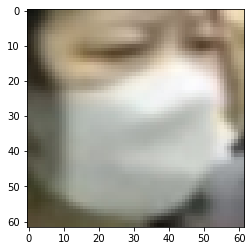

check feature_map of index 0


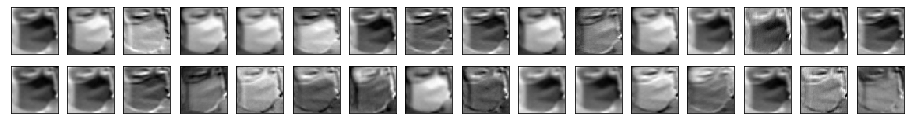

check feature_map of index 3


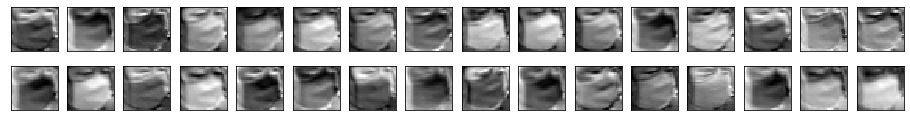

check feature_map of index 5


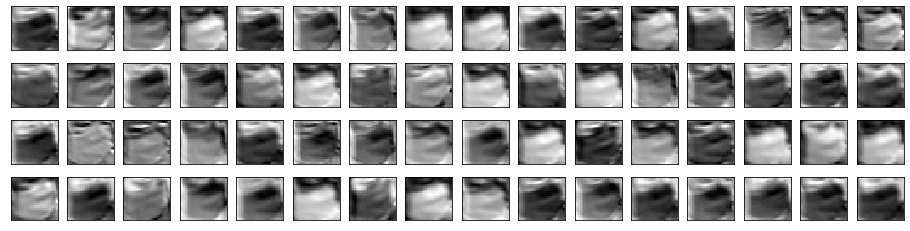

check feature_map of index 8


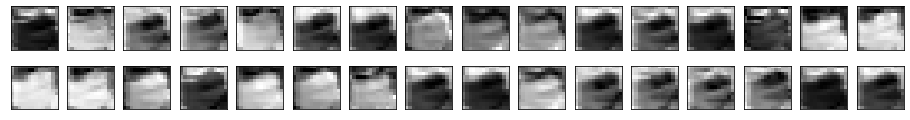

check feature_map of index 10


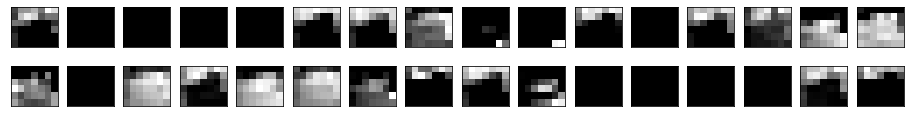

In [245]:
check_all_feature_map(val_x[0])

[[0.9994686]]


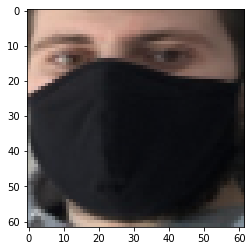

check feature_map of index 0


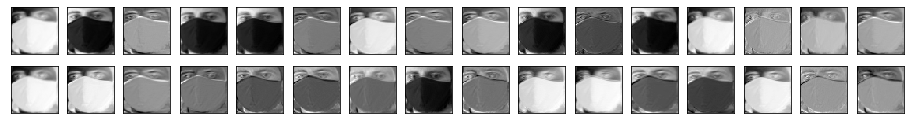

check feature_map of index 3


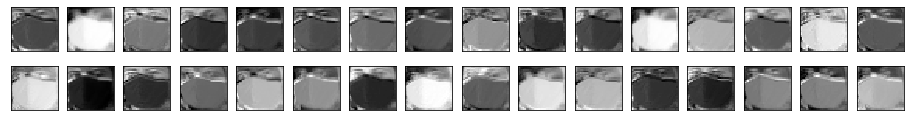

check feature_map of index 5


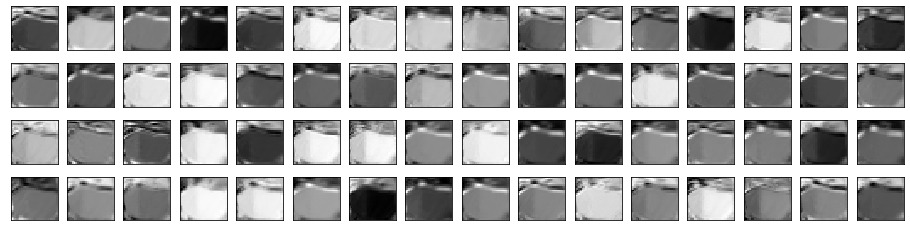

check feature_map of index 8


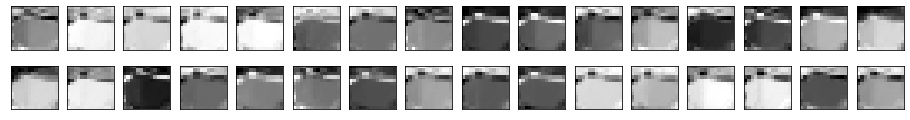

check feature_map of index 10


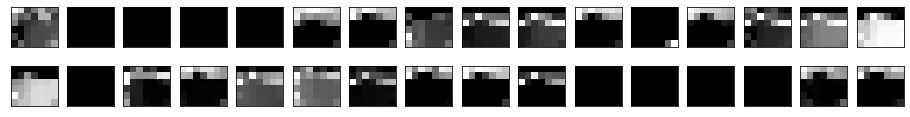

In [246]:
check_all_feature_map(val_x[200])

[[0.01064886]]


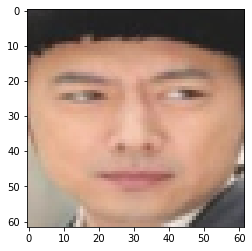

check feature_map of index 0


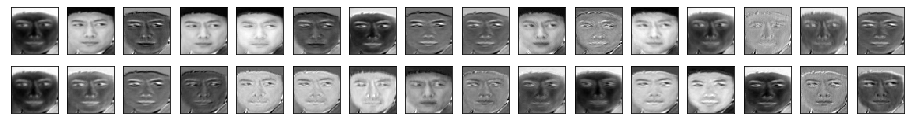

check feature_map of index 3


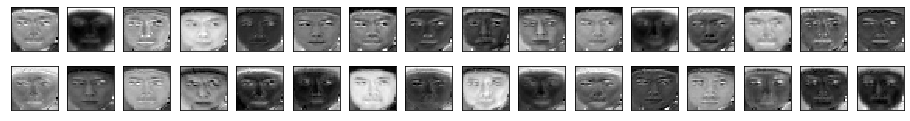

check feature_map of index 5


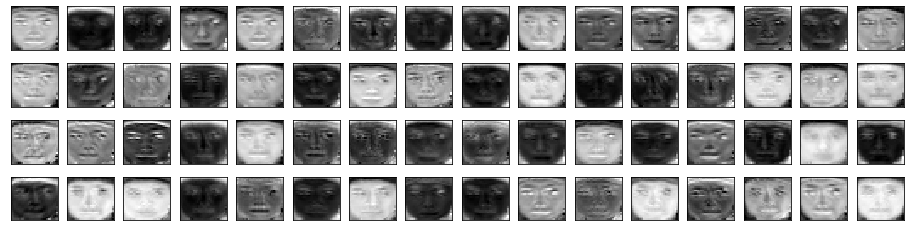

check feature_map of index 8


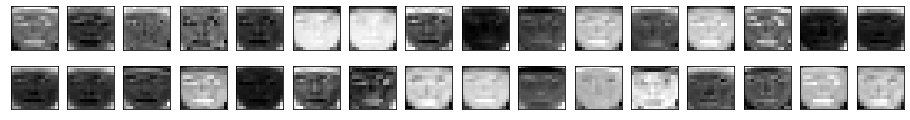

check feature_map of index 10


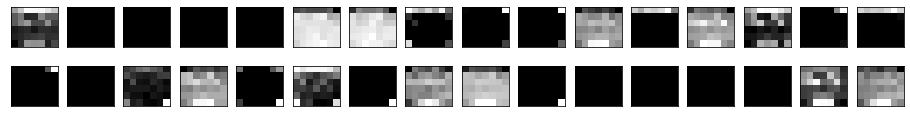

In [247]:
check_all_feature_map(val_x[400])

[[0.07348582]]


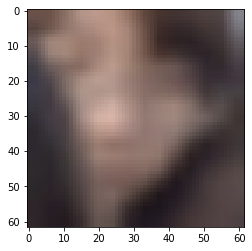

check feature_map of index 0


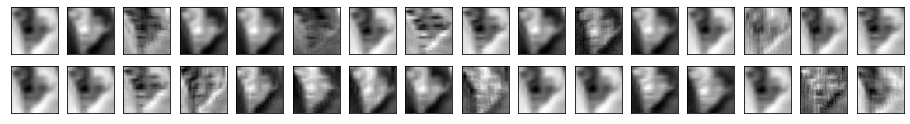

check feature_map of index 3


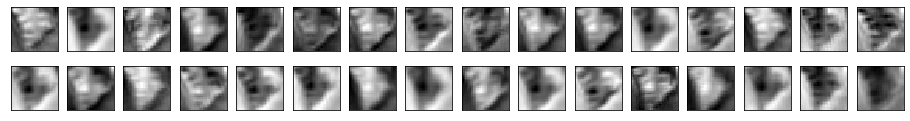

check feature_map of index 5


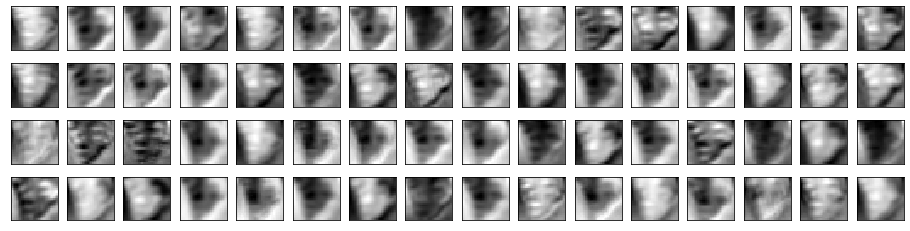

check feature_map of index 8


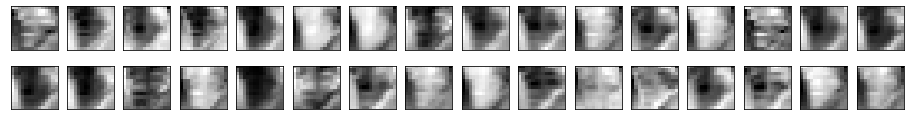

check feature_map of index 10


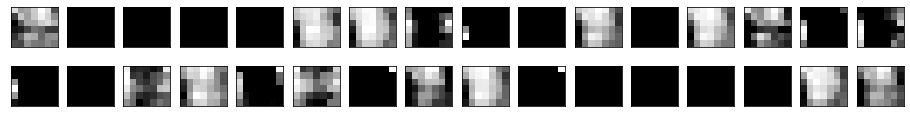

In [248]:
check_all_feature_map(val_x[300])

[[0.45181593]]


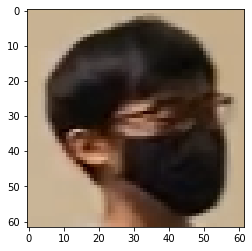

check feature_map of index 0


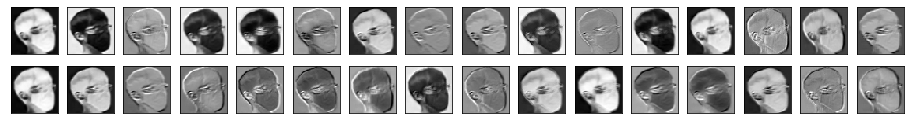

check feature_map of index 3


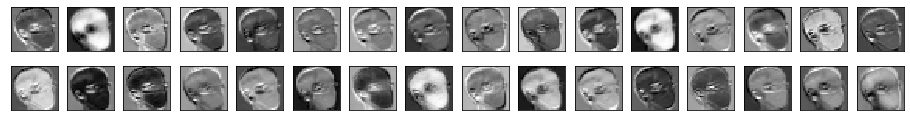

check feature_map of index 5


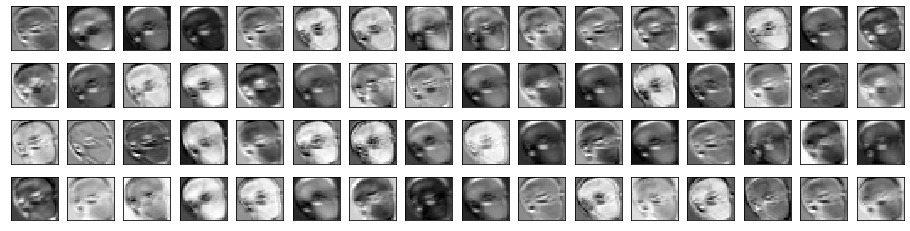

check feature_map of index 8


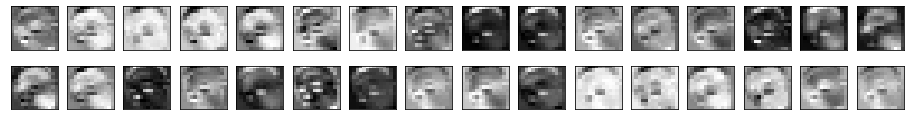

check feature_map of index 10


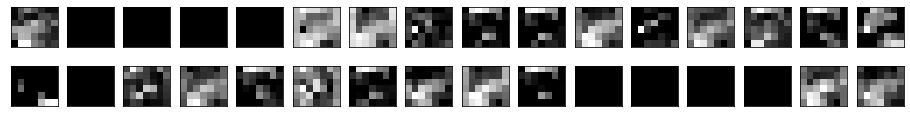

In [252]:
check_all_feature_map(cv2.resize(cv2.imread('./data/test_size0.PNG') / 255.0, resize_shape))

[[0.77487606]]


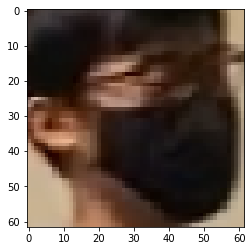

check feature_map of index 0


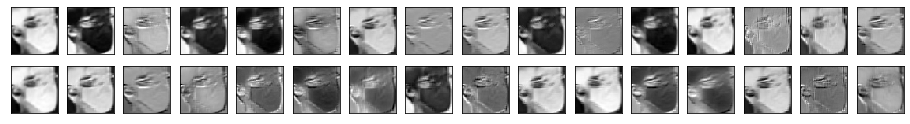

check feature_map of index 3


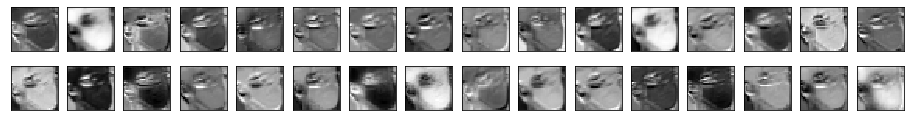

check feature_map of index 5


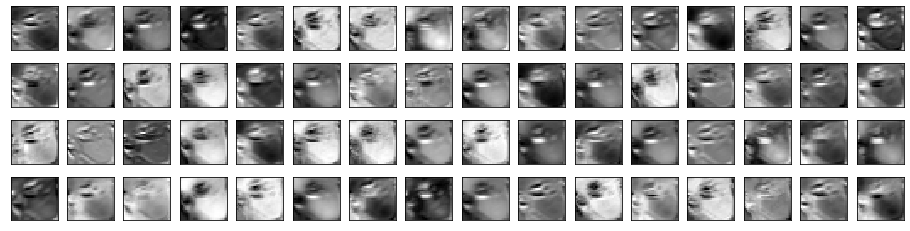

check feature_map of index 8


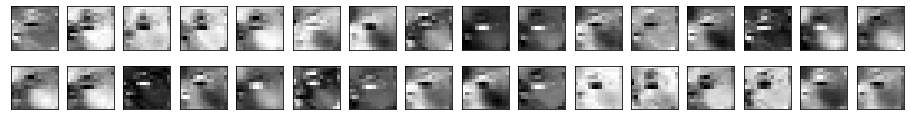

check feature_map of index 10


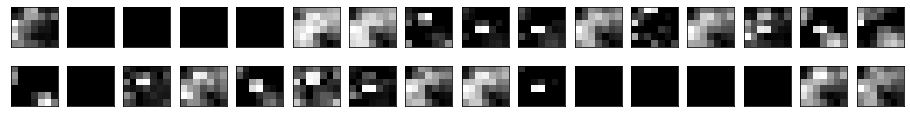

In [253]:
check_all_feature_map(cv2.resize(cv2.imread('./data/test_size1.PNG') / 255.0, resize_shape))

[[0.941427]]


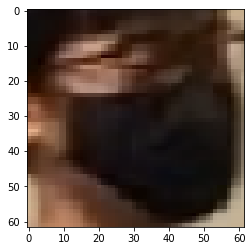

check feature_map of index 0


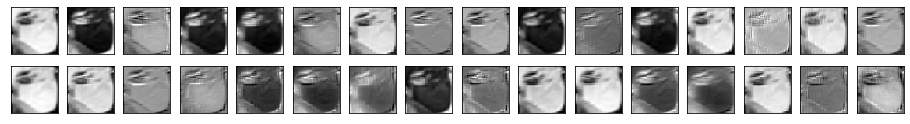

check feature_map of index 3


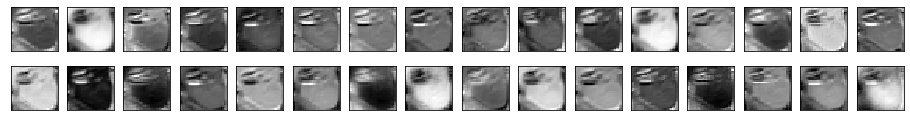

check feature_map of index 5


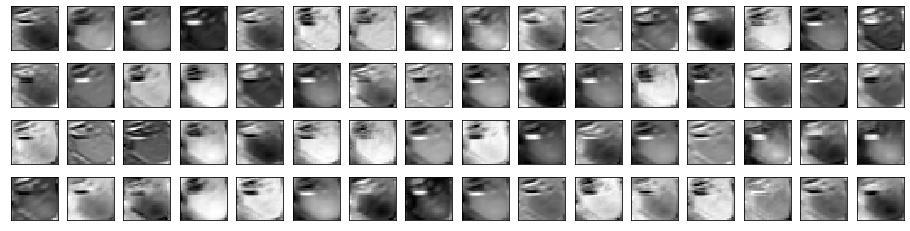

check feature_map of index 8


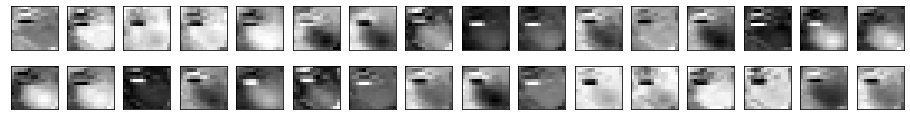

check feature_map of index 10


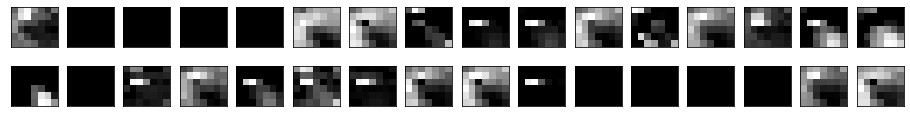

In [254]:
check_all_feature_map(cv2.resize(cv2.imread('./data/test_size2.PNG') / 255.0, resize_shape))

[[0.999982]]


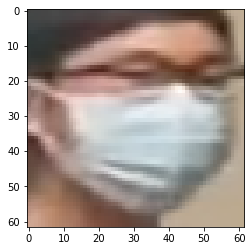

check feature_map of index 0


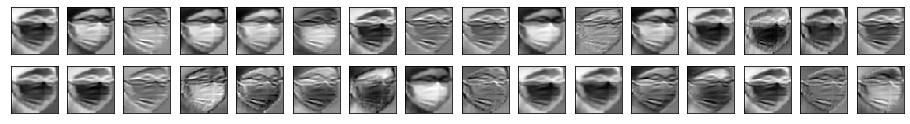

check feature_map of index 3


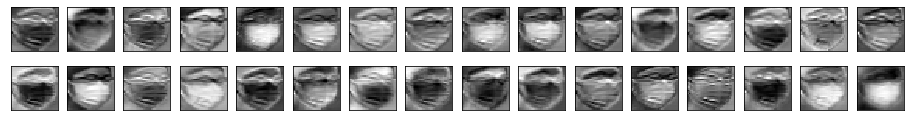

check feature_map of index 5


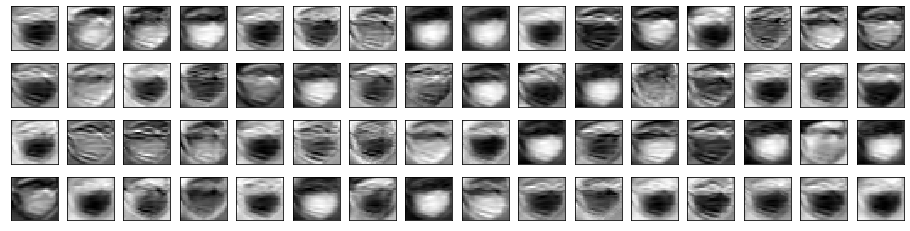

check feature_map of index 8


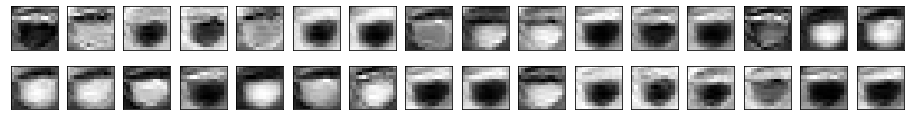

check feature_map of index 10


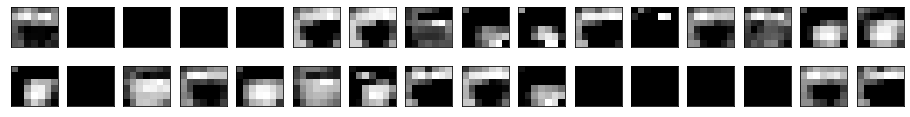

In [259]:
check_all_feature_map(cv2.resize(cv2.imread('./data/test_1_1.PNG') / 255.0, resize_shape))

In [260]:
model.save_weights('mask2.h5')